In [1]:
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read names that have provided survey eye color data
columns = ['name', 'left', 'right', 'left_desc', 'right_desc']

# pgp eye color data from survey
surveyData = pd.read_csv("./eye_color_data/PGP-eyecolor.csv", names=columns, na_values=['nan', ''])

# names of the pgp participants
surveyNames = np.asarray(surveyData['name'].values.tolist())

In [3]:
# load numpy array of names and keep only the huID
pgpNames = np.load("names.npy")
for i in range(len(pgpNames)):
    pgpNames[i] = pgpNames[i][:8]

# load numpy array of tiled PGP data 
pgp = np.load("hiq-pgp.npy")

In [4]:
# lookup a name in the survey data and return a tuple of the eye colors
def getData(name, surveyData):
    for index, row in surveyData.iterrows():
        if row['name'] == name:
            return (row['left'], row['right'])

In [5]:
# list of tuples for index and name with eye color data
namePairIndices = []

# dictionary of left and right eye colors with respective name, i.e., {"huID": 12}
nameLeftEyeMap = {}
nameRightEyeMap = {}

existingNames = []

# loop through pgpNames and add eye color to maps, making sure not to add the same name twice
for i in range(len(pgpNames)):
    name = pgpNames[i]
    if name in surveyNames and name not in existingNames:
        existingNames.append(name)
        eyeData = getData(name, surveyData)
        namePairIndices.append((i, name))
        nameLeftEyeMap[name] = eyeData[0]
        nameRightEyeMap[name] = eyeData[1]

# create lists containing the known eye color names and the unknown eye colors.
nameIndices = [nameIndex[0] for nameIndex in namePairIndices]
knownData = pgp[nameIndices]
unknownData = np.delete(pgp, nameIndices, axis=0)

In [6]:
# convert dictionaries to lists 
leftEyeNameList = []
rightEyeNameList = []

for nameTuple in namePairIndices:
    leftEyeNameList.append(nameLeftEyeMap[nameTuple[1]])
    rightEyeNameList.append(nameRightEyeMap[nameTuple[1]])
    
for i in range(len(leftEyeNameList)): # changes values to only blue/not blue for binary classification
    if leftEyeNameList[i] > 13:
        leftEyeNameList[i] = 0 # not blue
    else:
        leftEyeNameList[i] = 1 # blue

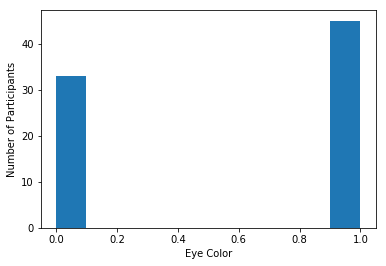

In [7]:
# create histogram of blue/not blue. TODO: make labels for graph

plt.hist(leftEyeNameList)
plt.ylabel("Number of Participants")
plt.xlabel("Eye Color")
plt.show()

In [8]:
# scale the data
knownData = preprocessing.scale(knownData.astype('double'))
knownData

array([[-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11396058,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [9]:
# 10-fold cross validation
svc_test = LinearSVC(penalty='l1', class_weight='balanced', 
                     C=.06, dual=False, verbose=1, max_iter=2500)
cv_scores = cross_val_score(svc_test, knownData, leftEyeNameList, cv=10, scoring='accuracy')
print
print cv_scores.mean()
print cv_scores.std()

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
0.855952380952
0.0946376575058


In [ ]:
# leave one out validation
from sklearn.model_selection import LeaveOneOut

leftOut = LeaveOneOut()
leftEyeNameList = np.asarray(leftEyeNameList)
scores = []
counter = 0
predicted = []
tested = []
for train_index, test_index in leftOut.split(knownData):
    X_train, X_test = knownData[train_index], knownData[test_index]
    y_train, y_test = leftEyeNameList[train_index], leftEyeNameList[test_index]
    svc_test.fit(X_train, y_train)
    y_pred = svc_test.predict(X_test)
    
    scores.append(accuracy_score(y_test, y_pred))
    predicted.append(y_pred)
    tested.append(y_test)
    
    counter += 1
    print "Iteration: " + str(counter) + ", correct: " + str(bool(y_test == y_pred))
    if not bool(y_test == y_pred):
        print "Incorrect: ", test_index

[LibLinear] Iteration: 1, correct: True
[LibLinear]Iteration: 2, correct: True
[LibLinear]Iteration: 3, correct: True
[LibLinear]Iteration: 4, correct: True
[LibLinear]Iteration: 5, correct: True
[LibLinear]Iteration: 6, correct: True
[LibLinear]Iteration: 7, correct: False
Incorrect:  [6]
[LibLinear]Iteration: 8, correct: True
[LibLinear]Iteration: 9, correct: False
Incorrect:  [8]
[LibLinear]Iteration: 10, correct: True
[LibLinear]Iteration: 11, correct: True
[LibLinear]Iteration: 12, correct: True
[LibLinear]Iteration: 13, correct: True
[LibLinear]Iteration: 14, correct: True
[LibLinear]Iteration: 15, correct: True
[LibLinear]Iteration: 16, correct: True
[LibLinear]Iteration: 17, correct: False
Incorrect:  [16]
[LibLinear]Iteration: 18, correct: True
[LibLinear]Iteration: 19, correct: True
[LibLinear]Iteration: 20, correct: True
[LibLinear]Iteration: 21, correct: True
[LibLinear]Iteration: 22, correct: True
[LibLinear]Iteration: 23, correct: True
[LibLinear]Iteration: 24, correct: T

In [ ]:
# print results of leave one out validation
print np.mean(np.asarray(scores))
import collections
print collections.Counter(scores)

In [ ]:
# create confusion matrix - code taken from Sarah's blood type prediction
cnf_matrix = confusion_matrix(predicted, tested)
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')

classes = ['Blue','Not Blue']

plt.grid('off')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color= "orangered")

plt.gcf().subplots_adjust(left=0.25, bottom = 0.35)

plt.savefig('Blue_Confusion.png',format='png',dpi=300)